In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import h5py
from glob import glob

archive = h5py.File("data/archive_18sco.hdf5", 'r')

In [174]:
solar_median = np.load('data/solar_median.npy')
wavelengths = np.load('data/residuals_wl.npy')

In [36]:
wl_min = 5156
wl_max = 5183

class Spectrum(object): 
    def __init__(self, wl, fl): 
        wl_range = ((wl < wl_max) & (wl > wl_min))
        self.wavelength = wl[wl_range]
        self.flux = fl[wl_range]

In [37]:
spectra = []
keys = list(archive)
for isot in keys: 
    sp = Spectrum(*archive[isot][:])
    spectra.append(sp)

In [38]:
from scipy.signal import correlate

[0 0 1 0 0 0 0 0 0 0 0 0 0] (13,) 2 4


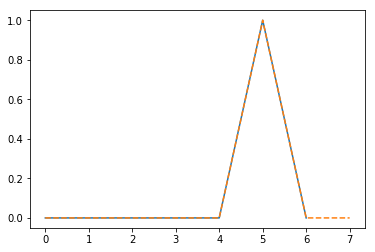

In [39]:
a = [0, 1, 0, 0, 0, 0, 0]
b = [0, 0, 0, 0, 0, 1, 0, 0]
minind = min([len(a), len(b)])
corr = np.correlate(a[:minind], b[:minind], mode='full')#[::-1]
ind_shift = (corr.shape[0])//2 - corr.argmax()
print(corr, corr.shape, corr.argmax(), ind_shift)

plt.plot(np.roll(a, ind_shift))
plt.plot(b, ls='--')
# plt.plot(corr)

In [40]:
# Expensive, only run once:
# dx = []
# for i in range(0, len(spectra)):
#     cross_corr = np.correlate(spectra[0].flux - np.median(spectra[0].flux), 
#                               spectra[i].flux - np.median(spectra[i].flux), mode='same')
    
#     dx.append(cross_corr.shape[0]//2 - cross_corr.argmax())

# np.save('data/dx_18sco.npy', dx)

dx = np.load('data/dx_18sco.npy')

In [41]:
from astropy.time import Time
dates = Time(keys, format='isot')

In [42]:
# for i, j in zip(dates.iso, all_fs): 
#     print(i, j)

In [43]:
from json import load
f_S = load(open('../f_S.json'))

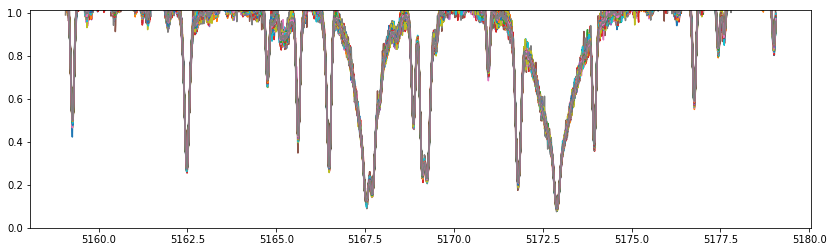

In [44]:
coadded = np.zeros_like(wavelengths) #spectra[0].flux

spectral_grid = None #spectra[0].flux #np.zeros((len(spectra)-1, len(spectra[0].wavelength)))
all_fs = []

delta_wavelength = np.median(np.abs(np.diff(spectra[0].wavelength)))

spectra_indices = []

plt.figure(figsize=(14, 4))
for i in range(0, len(spectra)): 
    # Quality filter
#     if True:
    if spectra[i].flux.max() < 1.2 and i > 2:
        spectra_indices.append(i)

        wavelength_shift = dx[i] * delta_wavelength
    
        rolled_spectrum = np.interp(wavelengths, spectra[i].wavelength - wavelength_shift, spectra[i].flux, left=1, right=1)
        rolled_spectrum /= np.median(rolled_spectrum)

        plt.plot(wavelengths, rolled_spectrum)
        coadded += rolled_spectrum
        if spectral_grid is None:
            spectral_grid = rolled_spectrum
        else:
            spectral_grid = np.vstack([spectral_grid, rolled_spectrum])

coadded /= np.median(coadded)
        
# plt.xlim([tio - 5, tio + 5])
plt.ylim([0, 1.01])
spectra_indices = np.array(spectra_indices)

In [73]:
import numpy as np
from scipy.spatial.distance import euclidean

from fastdtw import fastdtw

x = np.array([[1,1], [2,2], [3,3], [4,4], [5,5]])
y = np.array([[2,2], [3,3], [4,4]])
distance, path = fastdtw(x, y, dist=euclidean)
print(distance)

2.8284271247461903


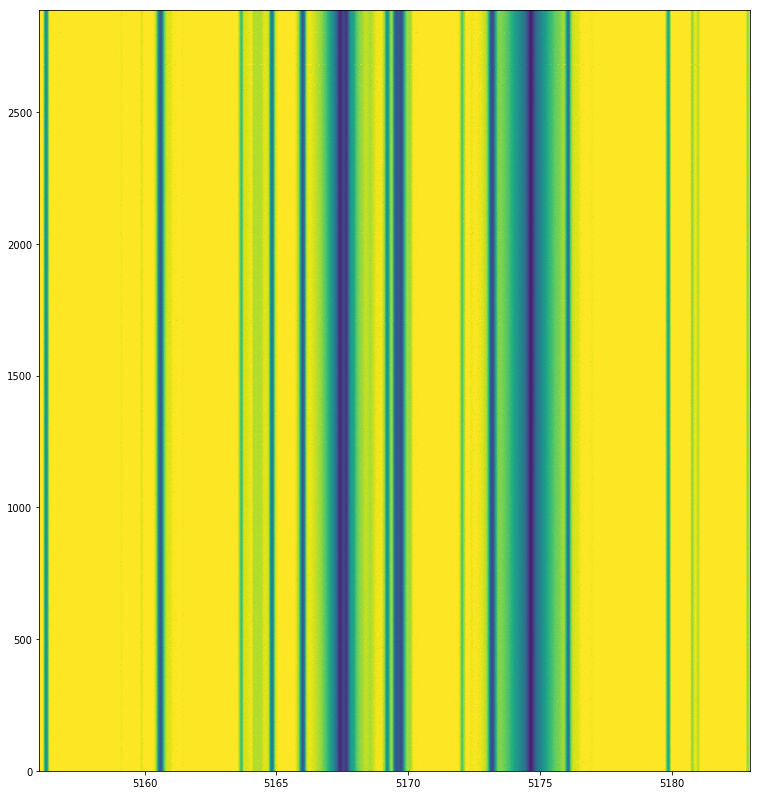

In [45]:
plt.figure(figsize=(14, 14))
extent = [spectra[0].wavelength.min(), spectra[0].wavelength.max(), 
          0, len(spectra_indices)]
plt.imshow(spectral_grid, origin='lower', extent=extent, vmin=0, vmax=1)
plt.gca().set_aspect(0.01)

In [78]:
from scipy.interpolate import interp1d

In [138]:
from scipy.optimize import fmin_l_bfgs_b

In [175]:
median_18sco = np.median(spectral_grid, axis=0)
cross_corr = np.correlate(median_18sco - np.median(median_18sco), 
                          solar_median - np.median(solar_median), mode='same')
dx = cross_corr.shape[0]//2 - cross_corr.argmax()
shift = dx * np.median(np.diff(wavelengths))

print(dx, shift)

# rolled_spectral_grid = np.roll(spectral_grid, dx, axis=1)
roll_range = np.arange(-100, 0)

chi2 = []
grid_median = np.median(spectral_grid, axis=0)
for r in roll_range:
    chi2.append(np.sum((np.roll(grid_median, r) - solar_median)**2))

shift = (roll_range[np.argmin(chi2)]) * np.median(np.diff(wavelengths))

def minfunc(p): 
    f = interp1d(p[1]*wavelengths + p[0], spectral_grid, bounds_error=False, fill_value=0)
    rolled_spectral_grid = f(wavelengths)
    return np.sum((solar_median - np.median(rolled_spectral_grid, axis=0))**2)

bounds = [[-1, 0], 
          [0, 2]]

result = fmin_l_bfgs_b(minfunc, [shift, 1], bounds=bounds, approx_grad=True)

print(result)
# plt.plot(wavelengths, solar_median)

-70 -0.7000000000152795
(array([-0.69999871,  1.00000087]), 74.46131580582012, {'grad': array([-0.4989019 , 63.96228258]), 'funcalls': 180, 'nit': 5, 'warnflag': 2, 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH'})


In [176]:
f = interp1d(result[0][1]*wavelengths + result[0][0], spectral_grid, bounds_error=False, fill_value=0)
rolled_spectral_grid = f(wavelengths)

# median_18sco = np.roll(median_18sco, dx)
# plt.plot(wavelengths, median_18sco)

(5166.5, 5167.2)

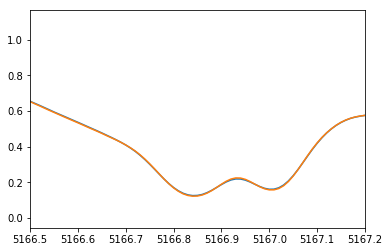

In [177]:
plt.plot(wavelengths, np.median(rolled_spectral_grid, axis=0))
plt.plot(wavelengths, solar_median)
plt.xlim([5166.5, 5167.2])

(0.95, 1.05)

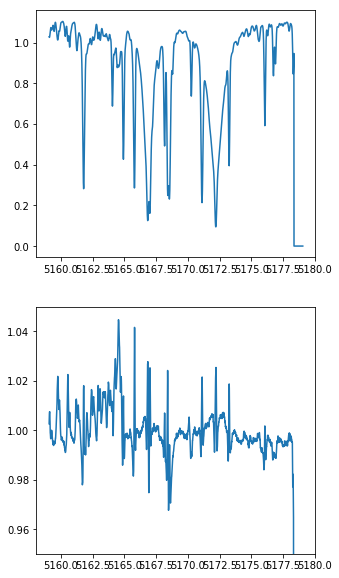

In [196]:
fig, ax = plt.subplots(2, 1, figsize=(5, 10))
ax[0].plot(wavelengths, np.median(rolled_spectral_grid, axis=0))
ax[1].plot(wavelengths, np.median(rolled_spectral_grid, axis=0) / solar_median)
ax[1].set_ylim([0.95, 1.05])
# plt.plot(wavelengths, solar_median)

(0.0, 1.05)

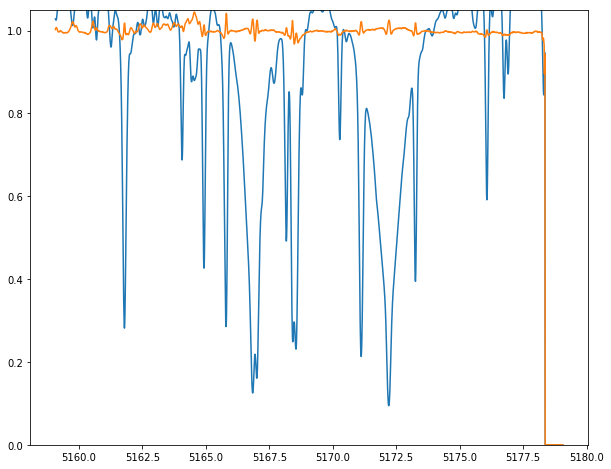

In [201]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(wavelengths, np.median(rolled_spectral_grid, axis=0))
# ax.plot(wavelengths, 10*(np.median(rolled_spectral_grid, axis=0) / solar_median - 1))
ax.plot(wavelengths, np.median(rolled_spectral_grid, axis=0) / solar_median)
ax.set_ylim([0.0, 1.05])
# plt.plot(wavelengths, solar_median)

In [179]:
residuals = np.zeros_like(rolled_spectral_grid)

wl_fit_min = 5160
wl_fit_max = 5178

wl_range = ((wavelengths < wl_fit_max) & (wavelengths > wl_fit_min))

for i in range(spectral_grid.shape[0]): 
    X = np.vstack([rolled_spectral_grid[i],
                   wavelengths - wavelengths.mean(), 
                   np.ones(len(wavelengths))]).T
    c = np.linalg.lstsq(X[wl_range], solar_median[wl_range])[0]
    residuals[i, :] = X @ c - solar_median
    residuals[i, ~wl_range] = 0
#     plt.plot(wavelengths, X @ c)

#     plt.plot(wavelengths, solar_median)
#     plt.show()
    
#     residuals[i, :] -= np.median(residuals[i, :])
#     residuals[i, :] /= residuals[i, :].ptp()

/Users/bmmorris/anaconda/lib/python3.5/site-packages/ipykernel_launcher.py:12: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  if sys.path[0] == '':


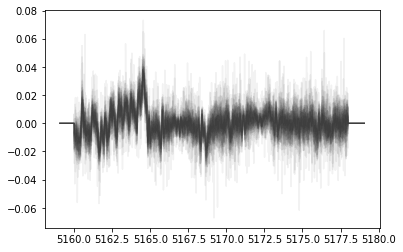

In [180]:
# for residual in residuals: 
#     plt.plot(residual, alpha=0.01, color='k')

plt.plot(wavelengths, residuals.T[:, :50:2], alpha=0.05, color='k')
plt.show()

In [181]:
residuals /= residuals.ptp(axis=0)

# plt.plot(median_residuals.T);

/Users/bmmorris/anaconda/lib/python3.5/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


In [182]:
np.save('data/residuals_18Sco.npy', residuals)

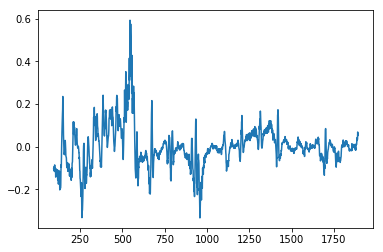

In [183]:
# plt.plot(residuals.T);
median_residuals = np.median(residuals, axis=0)
plt.plot(median_residuals)

In [184]:
from keras.models import load_model
model = load_model('data/model.hdf5')

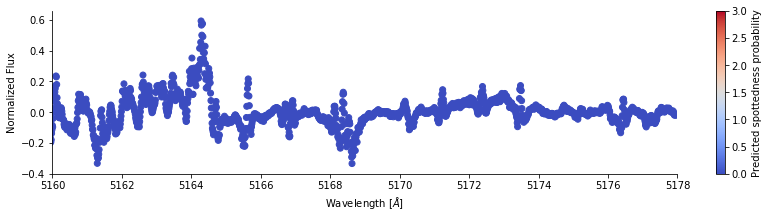

In [185]:
colors = []
window = 100
x = np.arange(len(wavelengths))

x_interps = []
y_not_interps = []
pred_ys = []

for i in range(window//2, len(wavelengths)-window//2):
    sliced = np.r_[0:i-window//2,i+window//2:len(wavelengths)]

    y_interped = np.interp(x, x[sliced], median_residuals[sliced])

    pred_y = model.predict(y_interped[np.newaxis, :, np.newaxis])

    x_interps.append(x[i])
    y_not_interps.append(median_residuals[i])
    pred_ys.append(pred_y.argmax(1)[0])

fig, ax = plt.subplots(figsize=(14, 3))
cax = plt.scatter(np.linspace(wavelengths.min(), wavelengths.max(), len(wavelengths)-window), 
                  y_not_interps, c=pred_ys, 
                  cmap=plt.cm.coolwarm, vmin=0, vmax=3)
cbar = plt.colorbar(cax)

ax.set_xlabel('Wavelength [$\AA$]')
ax.set_ylabel('Normalized Flux')
cbar.set_label('Predicted spottedness probability')
ax.set_xlim([wl_fit_min, wl_fit_max])
for s in ['right', 'top']:
    ax.spines[s].set_visible(False)
#     fig.savefig('plots/focus2.pdf', bbox_inches='tight')
#     plt.savefig('plots/focus2.png', bbox_inches='tight', dpi=200)
plt.show()

In [85]:
from scipy.interpolate import interp1d

In [169]:
# resample_residuals = interp1d(np.arange(residuals.shape[1]), residuals)(np.linspace(0, residuals.shape[1] - 1, residuals.shape[1] + 1))

predict_y = model.predict(residuals[:, :, np.newaxis])

(array([   0.,    0.,    0.,    0.,    0., 2888.,    0.,    0.,    0.,
           0.]),
 array([-0.5, -0.4, -0.3, -0.2, -0.1,  0. ,  0.1,  0.2,  0.3,  0.4,  0.5]),
 <a list of 10 Patch objects>)

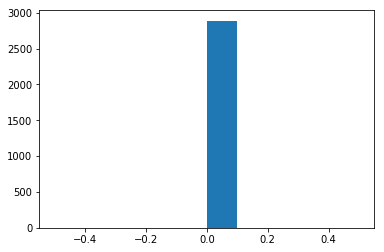

In [170]:
plt.hist(predict_y.argmax(axis=1))

In [75]:
predict_y.sum(0)

array([1803.3806   ,  929.197    ,   26.84134  ,    2.5785732],
      dtype=float32)

In [45]:
# np.median(resample_residuals, axis=0).shape

In [46]:
# plt.plot(np.median(resample_residuals, axis=0))

In [47]:
# predict_y_median = model.predict(np.median(resample_residuals, axis=0)[np.newaxis, :, np.newaxis])

In [48]:
# predict_y_median